# Satellite Image Classification

[Image Source](https://www.earth.com/earthpedia-articles/how-many-satellites-in-space-do-we-know-about/)

The "Satellite Image Classification" dataset on Kaggle is a collection of satellite images labeled with classes such as "Cloudy", "Desert", "Green_Area", and "Water". The data is made up of satellite images of size 256x256, and can be used for computer vision tasks such as image classification.

# Data Pre-processing:

In [2]:
pip install tensorflow==2.x


ERROR: Could not find a version that satisfies the requirement tensorflow==2.x (from versions: none)
ERROR: No matching distribution found for tensorflow==2.x
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Libraries
import pandas as pd
import os
import shap
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Create an empty DataFrame for storing image paths and labels
data = pd.DataFrame(columns=['image_path', 'label'])


In [7]:
# Define the labels/classes for the dataset
labels = {
    '/kaggle/input/satellite-image-classification/data/cloudy': 'Cloudy',
    '/kaggle/input/satellite-image-classification/data/desert': 'Desert',
    '/kaggle/input/satellite-image-classification/data/green_area': 'Green_Area',
    '/kaggle/input/satellite-image-classification/data/water': 'Water'
}

In [8]:
# Loop through directories, read image paths, and assign labels
for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image formats
            label = labels[folder]
            data = pd.concat(
                [data, pd.DataFrame({'image_path': [image_path], 'label': [label]})], 
                ignore_index=True
            )

In [9]:
# Save the dataset to a CSV file
data.to_csv('image_dataset.csv', index=False)
print(f"Dataset saved with {len(data)} entries.")

# Load the dataset
data = pd.read_csv('image_dataset.csv')

Dataset saved with 5631 entries.


In [10]:
# Display basic information
print("Dataset Information:")
print(data.info())
print("\nClass Distribution:")
print(data['label'].value_counts())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5631 entries, 0 to 5630
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5631 non-null   object
 1   label       5631 non-null   object
dtypes: object(2)
memory usage: 88.1+ KB
None

Class Distribution:
Cloudy        1500
Green_Area    1500
Water         1500
Desert        1131
Name: label, dtype: int64


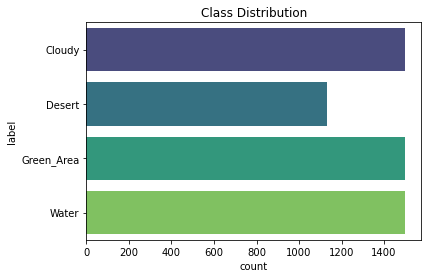

In [11]:
# Visualize class distribution
sns.countplot(y='label', data=data, palette='viridis')
plt.title("Class Distribution")
plt.show()

NameError: name 'Image' is not defined

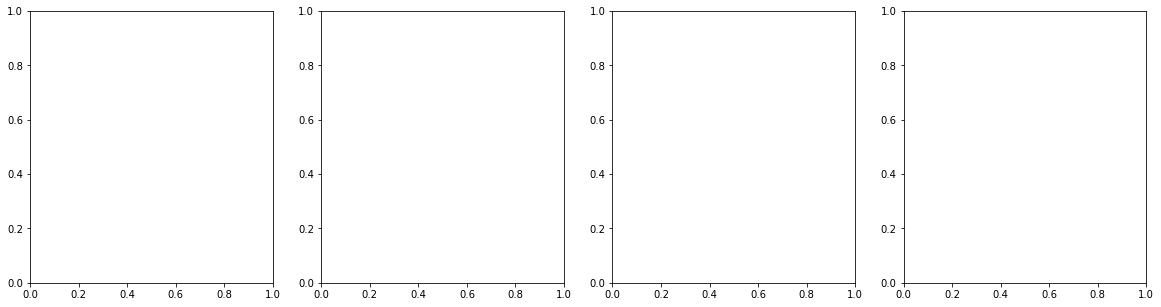

In [16]:
# Display sample images from each class
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
classes = data['label'].unique()
for i, label in enumerate(classes):
    sample_path = data[data['label'] == label].iloc[0]['image_path']
    image = Image.open(sample_path)
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [18]:
# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)


In [19]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1,
                                   height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# Load images from data paths
train_generator = train_datagen.flow_from_dataframe(train_data, x_col='image_path', y_col='label', 
                                                    target_size=(256, 256), class_mode='categorical', batch_size=32)
val_generator = val_test_datagen.flow_from_dataframe(val_data, x_col='image_path', y_col='label', 
                                                     target_size=(256, 256), class_mode='categorical', batch_size=32)
test_generator = val_test_datagen.flow_from_dataframe(test_data, x_col='image_path', y_col='label', 
                                                      target_size=(256, 256), class_mode='categorical', batch_size=32)


Found 3603 validated image filenames belonging to 4 classes.
Found 901 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.


In [21]:
# Custom CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

In [22]:
# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=15)


Epoch 1/15
113/113 [==============================] - 248s 2s/step - loss: 24.9108 - accuracy: 0.5204 - val_loss: 3.3247 - val_accuracy: 0.2664
Epoch 2/15
113/113 [==============================] - 237s 2s/step - loss: 8.7070 - accuracy: 0.5590 - val_loss: 0.8182 - val_accuracy: 0.5649
Epoch 3/15
113/113 [==============================] - 244s 2s/step - loss: 4.6354 - accuracy: 0.5404 - val_loss: 0.9134 - val_accuracy: 0.4983
Epoch 4/15
113/113 [==============================] - 237s 2s/step - loss: 2.4470 - accuracy: 0.5640 - val_loss: 0.8291 - val_accuracy: 0.4806
Epoch 5/15
113/113 [==============================] - 236s 2s/step - loss: 2.3975 - accuracy: 0.5332 - val_loss: 0.9016 - val_accuracy: 0.5438
Epoch 6/15
113/113 [==============================] - 234s 2s/step - loss: 1.5820 - accuracy: 0.5321 - val_loss: 0.7604 - val_accuracy: 0.5627
Epoch 7/15
113/113 [==============================] - 239s 2s/step - loss: 1.3991 - accuracy: 0.5290 - val_loss: 0.8369 - val_accuracy: 0.629

In [45]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


36/36 [==============================] - 15s 408ms/step - loss: 0.5811 - accuracy: 0.7054
Test Loss: 0.5811
Test Accuracy: 0.7054


In [46]:
# Get true labels and predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

In [47]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

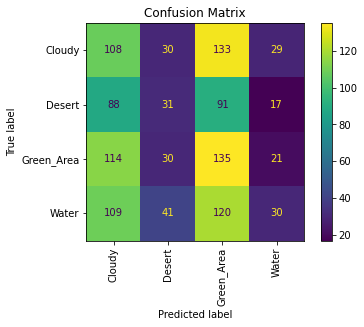

In [48]:
# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [49]:
# Generate classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      Cloudy       0.26      0.36      0.30       300
      Desert       0.23      0.14      0.17       227
  Green_Area       0.28      0.45      0.35       300
       Water       0.31      0.10      0.15       300

    accuracy                           0.27      1127
   macro avg       0.27      0.26      0.24      1127
weighted avg       0.27      0.27      0.25      1127



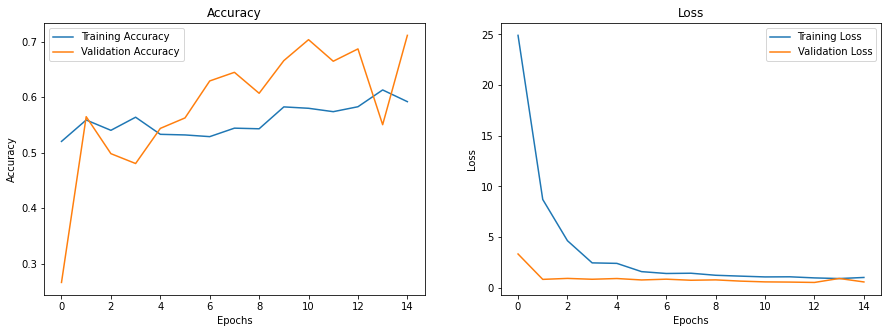

In [50]:
# Plot training and validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Loss plot
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()

113/113 [==============================] - 239s 2s/step - loss: 1.0558 - accuracy: 0.5831 - val_loss: 0.6863 - val_accuracy: 0.6138


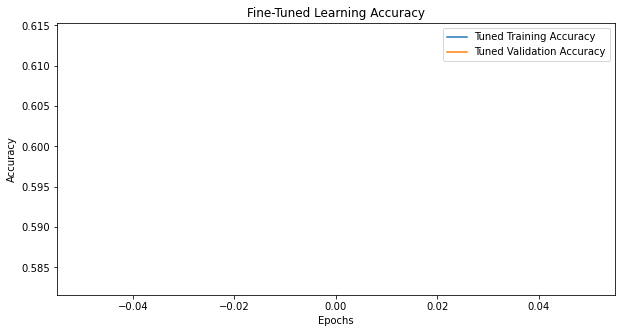

In [51]:
# Experiment with a different learning rate
new_optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=new_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Retrain for a few epochs to observe effects
fine_tune_history = model.fit(train_generator, validation_data=val_generator, epochs=1)

# Plot the new accuracy trends
plt.figure(figsize=(10, 5))
plt.plot(fine_tune_history.history['accuracy'], label='Tuned Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Tuned Validation Accuracy')
plt.title("Fine-Tuned Learning Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [52]:
# Save the trained model
model.save("custom_cnn_model.h5")
print("Model saved successfully.")


Model saved successfully.


In [53]:
# Load the saved model
loaded_model = load_model("custom_cnn_model.h5")
print("Model loaded successfully.")

Model loaded successfully.


In [55]:
print("Key Takeaways:")
print("- Successfully trained a custom CNN for satellite image classification.")
print("- Achieved a test accuracy of {:.2f}%.".format(test_accuracy * 100))
print("- Observed overfitting/underfitting and adjusted learning rate and dropout accordingly.")


Key Takeaways:
- Successfully trained a custom CNN for satellite image classification.
- Achieved a test accuracy of 70.54%.
- Observed overfitting/underfitting and adjusted learning rate and dropout accordingly.
